In [4]:
filepath = r"c:\Users\Lindsay\Documents\alexander\Honors\data_with_coords\Cas9-B1\P1000355\ts02DLC_resnet50_single_tadpoleNov23shuffle1_1030000.h5"


# Load Data

In [5]:
import pandas as pd
data_in = pd.read_hdf(filepath)

## Drop Scorer Row

In [112]:
data=data_in.copy()
data.columns = data.columns.droplevel(level='scorer')

# Functions

In [116]:
# function to adjust eyeball posistion sif ther eis a low likelihood for the position of an eye
def adjust_eyes(left_eye_column_in, right_eye_column_in, likelihood_threshold=0.998):
    # copy data
    left_eye_column= left_eye_column_in
    right_eye_column=  right_eye_column_in
    # check same shape input data
    if left_eye_column.shape!=right_eye_column.shape:
        # print("Error, shape of right and left eye data frames differs")
        return(pd.DataFrame([]))

    for i in range(left_eye_column.shape[0]):
        # If unsure of both eyes, replace with last known position or skip if i=0
        if left_eye_column.at[i,'likelihood']<likelihood_threshold and right_eye_column.at[i,'likelihood']<likelihood_threshold:
            if i==0:
                #print("Error, unsure of both eye positions on first data point, skipping correction")
                continue 
            else:
                left_eye_column.at[i,'x']= left_eye_column[i-1,'x']
                right_eye_column.at[i,'x']= right_eye_column[i-1,'x']
                left_eye_column.at[i,'y']= left_eye_column[i-1,'y']
                right_eye_column.at[i,'y']= right_eye_column[i-1,'y']
                print("unsure of both predictions of eyes, using previous")
                continue
    
        # If unsure of left eye only ( exclusive because of guard statement above)
        if left_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("left eye unsure as likelihood is " + str(left_eye_column.at[i,'likelihood']) + "\n replacing " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']) + " with " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']))
            left_eye_column.at[i,'x']= right_eye_column.at[i,'x']
            left_eye_column.at[i,'y']= right_eye_column.at[i,'y']
            

        # If unsure of Right eye only ( exclusive because of guard statement above)
        if right_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("right eye unsure as likelihood is " + str(right_eye_column.at[i,'likelihood']) + "\n replacing " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']) + " with " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']))
            right_eye_column.at[i,'x']= left_eye_column.at[i,'x']
            right_eye_column.at[i,'y']= left_eye_column.at[i,'y']
    return (left_eye_column, right_eye_column)


def get_frons(left_eye_column_in, right_eye_column_in):
    # function to calculate frons position - frons is halfway between the 2 eyes
    frons_x= (left_eye_column_in["x"]+right_eye_column_in["x"])/2
    frons_y=(left_eye_column_in["y"]+right_eye_column_in["y"])/2
    frons_index = pd.MultiIndex.from_product([["frons"], ["x", "y"]])
    frons_df = pd.DataFrame( columns=frons_index)
    frons_df[("frons", "x")] = frons_x
    frons_df[("frons", "y")] = frons_y
    return frons_df

def get_com(left_eye_column_in, right_eye_column_in, tail_base_column_in):
    # function to calculate centre of mass of the tadpole
    com_x= (left_eye_column_in["x"]+right_eye_column_in["x"]+tail_base_column_in["x"])/3
    com_y=(left_eye_column_in["y"]+right_eye_column_in["y"]+tail_base_column_in["y"])/3
    com_index = pd.MultiIndex.from_product([["com"], ["x", "y"]])
    com_df = pd.DataFrame( columns=com_index)
    com_df[("com", "x")] = com_x
    com_df[("com", "y")] = com_y
    return com_df


## Adjust Eyes

In [113]:
data['left_eye'], data['right_eye'] = adjust_eyes(data['left_eye'], data['right_eye'])


## Create Frons

In [114]:
#get_frons(data['left_eye'], data['right_eye'])
frons_df = get_frons(data['left_eye'], data['right_eye'])
data=pd.concat([data, frons_df], axis=1)


# Create Centre of Mass

In [117]:
com_df = get_com(data['left_eye'], data['right_eye'], data['tail_base'])
data=pd.concat([data, com_df], axis=1)

# Plot Tadpole Position

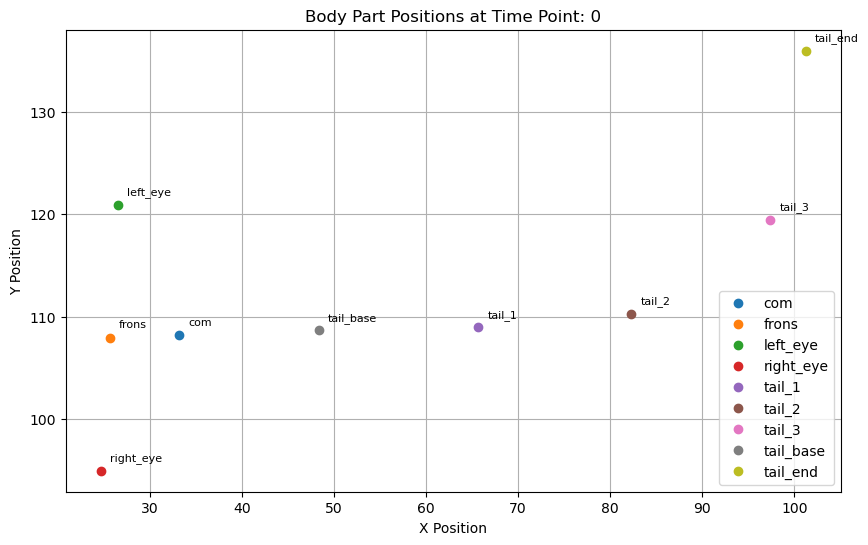

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
idx_to_visualise=0
# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
plt.figure(figsize=(10, 6))  # Set plot size

# Loop through each body part
for bodypart in bodyparts:
    # Select data for this body part (all rows)
    bodypart_data = data.loc[idx_to_visualise, bodypart]  # Select specific level and column

    # Extract x and y data
    x_position = bodypart_data['x']
    y_position = bodypart_data['y']

    # Plot the points with labels
    plt.plot(x_position, y_position, 'o', label=bodypart)  # Plot and label
    plt.text(x_position + 1, y_position + 1, bodypart, fontsize=8)  # Add text label

# Configure plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Body Part Positions at Time Point: " + str(idx_to_visualise))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [121]:
data.columns

MultiIndex([( 'left_eye',          'x'),
            ( 'left_eye',          'y'),
            ( 'left_eye', 'likelihood'),
            ('right_eye',          'x'),
            ('right_eye',          'y'),
            ('right_eye', 'likelihood'),
            ('tail_base',          'x'),
            ('tail_base',          'y'),
            ('tail_base', 'likelihood'),
            (   'tail_1',          'x'),
            (   'tail_1',          'y'),
            (   'tail_1', 'likelihood'),
            (   'tail_2',          'x'),
            (   'tail_2',          'y'),
            (   'tail_2', 'likelihood'),
            (   'tail_3',          'x'),
            (   'tail_3',          'y'),
            (   'tail_3', 'likelihood'),
            ( 'tail_end',          'x'),
            ( 'tail_end',          'y'),
            ( 'tail_end', 'likelihood'),
            (    'frons',          'x'),
            (    'frons',          'y'),
            (      'com',          'x'),
            (   